In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    stratify=y, 
                                                    random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426,), (143,))

In [5]:
optimal_model = LogisticRegression(max_iter=1000, 
                                    tol=0.0, #10**(-100), # disable stopping criteria
                                    random_state=42,
                                    class_weight='balanced')

In [18]:
optimal_model.fit(X_train, y_train)
optimal_preds = optimal_model.predict_proba(X_test)[:, 1]
optimal_preds_discrete = np.where(optimal_preds > 0.5, 1, 0)
len(y_test[optimal_preds_discrete != y_test]), len(y_test)

(5, 143)

In [ ]:
optimal_model = LogisticRegression(max_iter=1000, 
                                    tol=0.0, #10**(-100), # disable stopping criteria
                                    random_state=0,
                                    class_weight='balanced')
optimal_model.fit(X_train, y_train)

optimal_preds = optimal_model.predict_proba(X_test)[:, 1]
optimal_preds_discrete = np.where(optimal_preds > 0.5, 1, 0)
len(y_test[optimal_preds_discrete != y_test])

5

In [125]:
optimal_model.n_iter_

array([48])

In [104]:
print("Accuracy: ", accuracy_score(y_test, optimal_preds_discrete),\
"\nPrecision: ",precision_score(y_test, optimal_preds_discrete),\
"\nRecall: ",recall_score(y_test, optimal_preds_discrete),\
"\nF1: ",f1_score(y_test, optimal_preds_discrete))


Accuracy:  0.965034965034965 
Precision:  0.9885057471264368 
Recall:  0.9555555555555556 
F1:  0.9717514124293786


In [105]:
optimal_model.coef_[0], optimal_model.intercept_[0]

(array([-0.46804587, -0.46793786, -0.42714584, -0.5197265 , -0.31905578,
         0.82893192, -0.5385251 , -0.69212213, -0.12360512,  0.02185378,
        -1.14329979,  0.21789711, -0.4520087 , -0.98549475, -0.12524279,
         0.61025817,  0.20901537, -0.39699473,  0.45169458,  0.3679131 ,
        -0.93229522, -1.27819147, -0.69949539, -0.95704949, -0.59245943,
         0.03313409, -0.82076211, -0.99456967, -0.95030037, -0.20616347]),
 -0.1294311297730778)

In [106]:
# simulate rejection sampling
predictions = []
for seed in range(1000):
    start_time = time.time()
    model = LogisticRegression(max_iter=1000, 
                                tol=0, 
                                random_state=seed)
    model.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_test)[:, 1]
    predictions.append(pred_proba)
    print("\n\nSeed: ",seed, "Time taken: ", time.time() - start_time)
    pred_proba_discrete = np.where(pred_proba > 0.5, 1, 0)
    print("Accuracy: ", accuracy_score(y_test, pred_proba_discrete))#,\
    # "\nPrecision: ",precision_score(y_test, pred_proba_discrete),\
    # "\nRecall: ",recall_score(y_test, pred_proba_discrete),\
    # "\nF1: ",f1_score(y_test, pred_proba_discrete))
    print(model.n_iter_)
    
predictions = np.array(predictions)



Seed:  0 Time taken:  0.019414186477661133
Accuracy:  0.986013986013986
[50]


Seed:  1 Time taken:  0.018512725830078125
Accuracy:  0.986013986013986
[50]


Seed:  2 Time taken:  0.018604040145874023
Accuracy:  0.986013986013986
[50]


Seed:  3 Time taken:  0.01703357696533203
Accuracy:  0.986013986013986
[50]


Seed:  4 Time taken:  0.018500089645385742
Accuracy:  0.986013986013986
[50]


Seed:  5 Time taken:  0.01869344711303711
Accuracy:  0.986013986013986
[50]


Seed:  6 Time taken:  0.01787853240966797
Accuracy:  0.986013986013986
[50]


Seed:  7 Time taken:  0.27181458473205566
Accuracy:  0.986013986013986
[50]


Seed:  8 Time taken:  0.020154953002929688
Accuracy:  0.986013986013986
[50]


Seed:  9 Time taken:  0.018983125686645508
Accuracy:  0.986013986013986
[50]


Seed:  10 Time taken:  0.021529197692871094
Accuracy:  0.986013986013986
[50]


Seed:  11 Time taken:  0.019313335418701172
Accuracy:  0.986013986013986
[50]


Seed:  12 Time taken:  0.01900005340576172
Accuracy:

In [ ]:
# generate vicinal models
epsilon = 0.01  # same in the paper
vicinal_models = []

for _ in range(100):
    # random direction in weight space
    direction = np.random.randn(len(optimal_model.coef_[0]))
    direction = direction / np.linalg.norm(direction)
    
    # scale by random amount within epsilon
    scale = np.random.uniform(0, epsilon)
    new_weights = optimal_model.coef_[0] + scale * direction
    
    model = LogisticRegression()
    model.classes_ = optimal_model.classes_
    model.coef_ = new_weights.reshape(1, -1)
    model.intercept_ = optimal_model.intercept_
    vicinal_models.append(model)

In [118]:
vicinal_preds = np.array([model.predict_proba(X_test)[:, 1] for model in vicinal_models])
vicinal_preds

array([[9.55320073e-01, 2.70364158e-04, 4.63515022e-01, ...,
        9.97156766e-01, 9.52940070e-01, 9.98929973e-01],
       [9.55047898e-01, 2.71541868e-04, 4.64448867e-01, ...,
        9.97148365e-01, 9.52727832e-01, 9.98918537e-01],
       [9.55085892e-01, 2.70994583e-04, 4.64179407e-01, ...,
        9.97153957e-01, 9.52859157e-01, 9.98920849e-01],
       ...,
       [9.54937369e-01, 2.72235456e-04, 4.64329073e-01, ...,
        9.97137506e-01, 9.52729550e-01, 9.98919599e-01],
       [9.55066906e-01, 2.71293161e-04, 4.64308275e-01, ...,
        9.97150031e-01, 9.52707670e-01, 9.98919338e-01],
       [9.55039224e-01, 2.70300092e-04, 4.63875886e-01, ...,
        9.97143598e-01, 9.52702994e-01, 9.98921045e-01]])

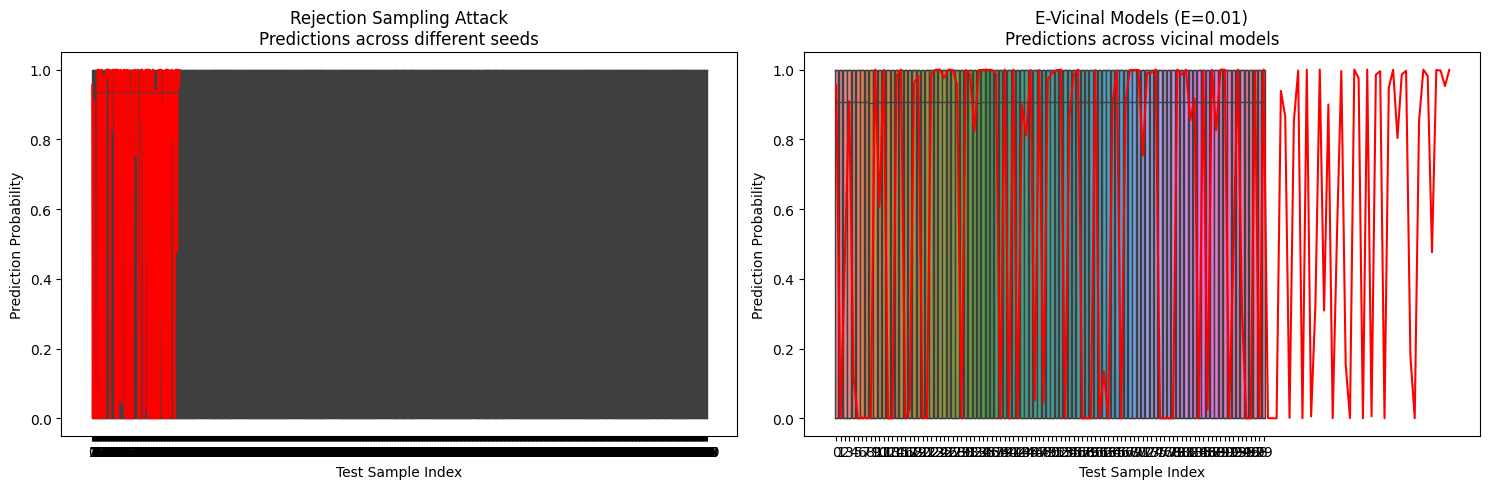

In [119]:
# Analyze results
plt.figure(figsize=(15, 5))
    
# Plot: Rejection Sampling Attack
plt.subplot(121)
sns.boxplot(data=predictions.T)
plt.plot(optimal_preds, 'r-', label='Optimal Model')
plt.title('Rejection Sampling Attack\nPredictions across different seeds')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Probability')

# Plot: E-Vicinal Models
plt.subplot(122)
sns.boxplot(data=vicinal_preds.T)
plt.plot(optimal_preds, 'r-', label='Optimal Model')
plt.title(f'E-Vicinal Models (E={epsilon})\nPredictions across vicinal models')
plt.xlabel('Test Sample Index')
plt.ylabel('Prediction Probability')

plt.tight_layout()
plt.show()

In [120]:
# Calculate theoretical error bound
X_norms = np.linalg.norm(X_test, axis=1)
max_error_bound = 0.25 * np.max(X_norms) * epsilon
print(f"Maximum theoretical prediction error bound: {max_error_bound:.4f}")

Maximum theoretical prediction error bound: 0.0538
